In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple
import yfinance as yf

In [64]:
ticker = "AAPL"
interval = "1d"
start_dt_train = "2024-01-01"
end_dt_train = "2024-11-30"
start_dt_test = "2024-12-01"
end_dt_test = "2025-01-13"
num_steps = 251
delta_t = 1/num_steps
expiry_dt = "2025-01-17"
rfr_ticker = "^IRX"
num_sims = 100

In [65]:
def get_risk_free(ticker: str, num_steps:int, start_dt: str, end_dt: str) -> pd.DataFrame:
    risk_free_data = yf.download(ticker, start=start_dt, end=end_dt, progress=False)

    annual_yield_percent = risk_free_data['Close'].iloc[-1]  # In percent
    annual_yield = annual_yield_percent / 100  # Convert to decimal
    daily_rate = annual_yield / num_steps # Get daily rate
    daily_continuous_rate = np.log(1 + daily_rate) # Continuous compounding
    return daily_continuous_rate

def get_price_data(ticker: str, start_dt: str, end_dt: str, interval: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start_dt, end=end_dt,interval=interval, progress=False)
    df = df.reset_index()
    new_columns = df.columns.get_level_values(0).tolist()
    new_columns[0] = 'Date'  
    new_columns[1] = 'Close'  

    df.columns = df.columns.droplevel(1) 
    df.columns = new_columns

    df = df.set_index('Date').rename_axis(None)
    df['Daily Return'] = df['Close'].pct_change()

    df = df[~df['Daily Return'].isnull()] 
    df = df[['Close', 'Daily Return']]
    return df

def get_option_data(ticker: str, expiry_dt: str) -> Tuple[pd.DataFrame, pd.DataFrame]:

    stock = yf.Ticker(ticker)
    if expiry_dt not in stock.options:
        raise ValueError(f"Expiry date {expiry_dt} not available for ticker {ticker}. Available dates: {stock.options}")
        
    option_chain = stock.option_chain(expiry_dt)
        
    return option_chain.calls, option_chain.puts

In [79]:
daily_continuous_rate_train = get_risk_free(rfr_ticker, num_steps, start_dt_train, end_dt_train)
stock_data_train = get_price_data(ticker, start_dt_train, end_dt_train, interval)
daily_continuous_rate_test = get_risk_free(rfr_ticker, num_steps, start_dt_test, end_dt_test)
stock_data_test = get_price_data(ticker, start_dt_test, end_dt_test, interval)
calls, puts = get_option_data(ticker, expiry_dt)
stock_data_train['realized_variance'] = stock_data_train['Daily Return']**2
stock_data_train['variance_diff'] = stock_data_train['realized_variance'].diff()

In [67]:
# Heston model
S0 = stock_data_train['Close'][-1]
T_train = (pd.to_datetime(expiry_dt) - pd.to_datetime(start_dt_train)).days / 365
T_test = (pd.to_datetime(expiry_dt) - pd.to_datetime(start_dt_test)).days / 365
r = daily_continuous_rate_train.mean()

realized_volatility = stock_data_train['Daily Return'].std()  # Standard deviation of daily returns
theta = realized_volatility ** 2  # Variance

v0 = stock_data_train['Daily Return'][-30:].var()  # Variance of last 30 days
rho_train = stock_data_train['Daily Return'].corr(stock_data_train['variance_diff'])
kappa = 2.0  
sigma = 0.5      

/var/folders/v2/yp6ykh395fg_mglzjglsfl1m0000gn/T/ipykernel_41708/346828448.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = stock_data_train['Close'][-1]


In [68]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)

    return S, v

In [69]:
S_p,v_p = heston_model_sim(S0, v0, rho_train, kappa, theta, sigma,T_train, num_steps, num_sims)

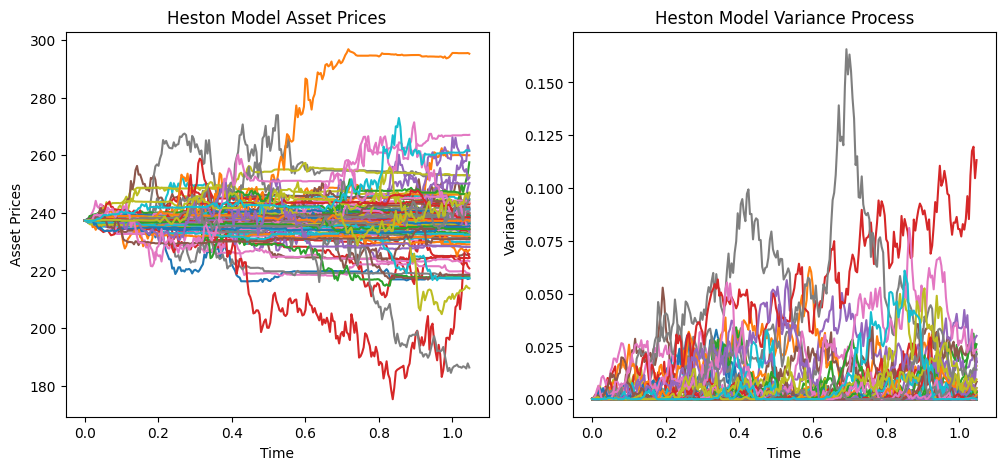

In [70]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T_train,num_steps+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

In [81]:
K = calls['strike'].iloc[0]  
payoffs = np.maximum(S_p[-1, :] - K, 0)
expected_payoff = np.mean(payoffs)
option_price = np.exp(-r * T_train) * expected_payoff
option_price

np.float64(232.11878434434874)